**Image2Image Pipeline for Stable Diffusion using Gradio**

In [1]:
!nvidia-smi

Mon Nov 27 16:41:09 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB           Off | 00000000:62:00.0 Off |                    0 |
| N/A   47C    P0              54W / 300W |  10237MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os

# Get your own process ID (PID)
pid = os.getpid()

print(f"Your process ID (PID): {pid}")

Your process ID (PID): 1128429


In [3]:
# !pip install -qq -U transformers==4.26.1 ftfy gradio diffusers

In [4]:
# !pip install -qq "ipywidgets>=7,<8"

In [5]:
# !pip install diffusers

In [6]:
# !pip install replicate

In [7]:
# !pip freeze > requirements.txt

In [8]:
from huggingface_hub import notebook_login

notebook_login()

In [9]:
import sys
import inspect
import warnings
from typing import List, Optional, Union

import torch
from torch import autocast
from tqdm.auto import tqdm

from diffusers import StableDiffusionImg2ImgPipeline

import asyncio

import os
clip_interrogator_path = '/home/ochirpurev/.local/lib/python3.10/site-packages/'
replicate_path = '/home/ochirpurev/.local/lib/python3.10/site-packages'
sys.path.append(replicate_path)
sys.path.append(clip_interrogator_path)

from clip_interrogator import Config, Interrogator
import replicate

2023-11-27 16:41:12.216317: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-27 16:41:13.258756: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [10]:
device = "cuda"
model_path = "CompVis/stable-diffusion-v1-4"

from diffusers import DiffusionPipeline

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_path,
    revision="fp16",
    torch_dtype=torch.float16,
    use_auth_token=True
).to(device)
pipe = pipe

unet/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

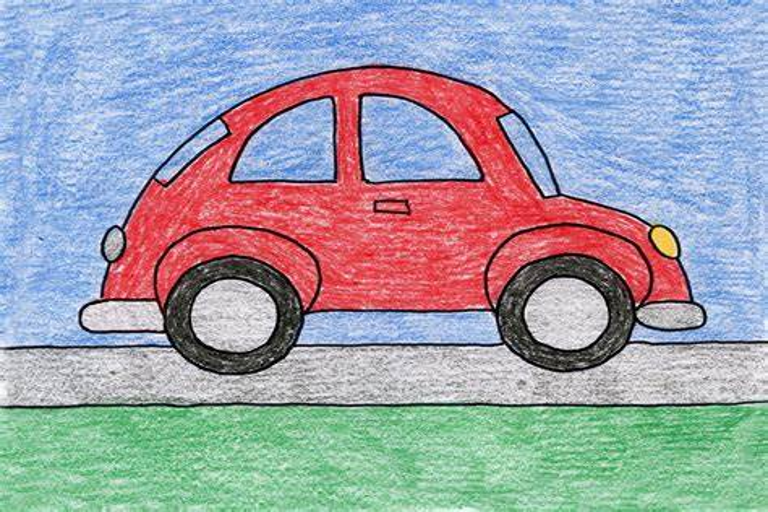

In [11]:
import requests
from io import BytesIO
from PIL import Image

url = "https://th.bing.com/th/id/OIP.ohGkZC2yTgsR4wv6GNnADAHaFu?pid=ImgDet&rs=1"

response = requests.get(url)
init_img = Image.open(BytesIO(response.content)).convert("RGB")
init_img = init_img.resize((768, 512))
init_img

In [12]:
#Define the prompt
prompt = "the offroad racing car"

In [13]:
generator = torch.Generator(device=device).manual_seed(1024)
with autocast("cuda"):
    image = pipe(prompt=prompt, image=init_img, strength=0.6, guidance_scale=7.5, generator=generator).images[0]

  0%|          | 0/30 [00:00<?, ?it/s]

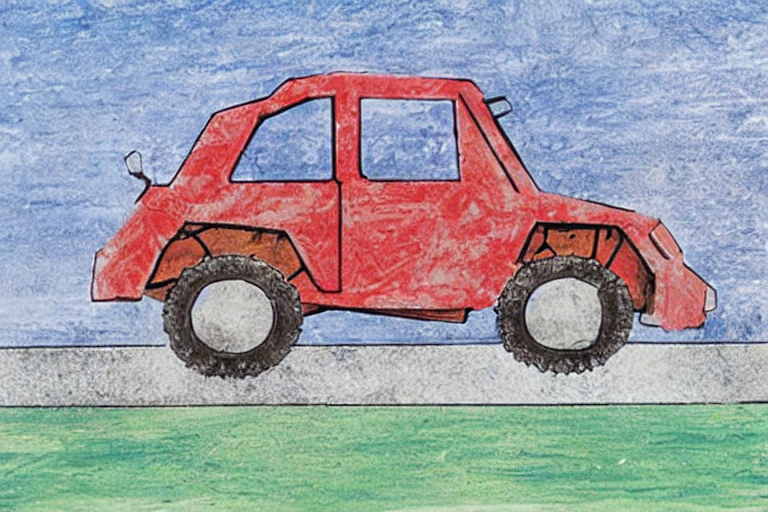

In [14]:
image

**Import Gradio framework and required dependencies**

In [15]:
# !pip install gradio

In [16]:
import gradio as gr
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from PIL import Image as PILImage

**Define a folder to save the sketches**

In [17]:
save_folder = "/home/ochirpurev/sketches"  # Use an accessible directory in Colab
!mkdir -p $save_folder

**Define a prompt here**

In [18]:
prompt="a stydio ghibli-like art style a house in a countryside in a cartoon like world and with children book illustration and beautiful anime-like"

**Enhance Enhancer function, where the user can directly upload the sketch**

In [19]:
def enhance_image_upload(sketch):
    # Generate a unique filename
    filename = f"{save_folder}/sketch.png"
    image_data = np.array(sketch)
    # extent = (0, sketch.width, 0, sketch.height)

    # Save the sketch as a PNG file
    plt.imsave(filename, image_data, cmap="viridis", origin="upper")
    
    # Open the saved image using PIL
    saved_image = PILImage.open(filename)
    saved_image = saved_image.convert("RGB").resize((512, 512)) 
    generator = torch.Generator(device=device).manual_seed(1024)

    with autocast("cuda"):
        return_image = pipe(prompt=prompt, image=saved_image, strength=0.55, guidance_scale=7.5, generator=generator).images[0]
    return return_image

**Enhance Enhancer function**

In [20]:
def enhance_image_sketch(sketch, prompt_input):
    # Generate a unique filename
    filename = f"{save_folder}/sketch.png"
    image_data = np.array(sketch)
    # extent = (0, sketch.width, 0, sketch.height)

    # Save the sketch as a PNG file
    plt.imsave(filename, image_data, cmap="viridis", origin="upper")
    
    # Open the saved image using PIL
    saved_image = PILImage.open(filename)
    saved_image = saved_image.convert("RGB").resize((512, 512)) 
    generator = torch.Generator(device=device).manual_seed(1024)
    # return_image
    with autocast("cuda"):
        return_image = pipe(prompt=prompt_input, image=saved_image, strength=0.65, guidance_scale=7.5, generator=generator).images[0]

    return return_image

**Run sketch_enhancer_upload function to debug the sketch_enhancer function without drawing the sketch**

In [21]:
sketch_enhancer_upload = gr.Interface(
    fn=enhance_image_upload, 
    inputs="image", 
    outputs="image").queue().launch(share=True, inline=False)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://2bf57c716caaf147cf.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


**Run the sketch_enhancer to draw the input sketch**

In [22]:
input_sketchpad =gr.Paint(label="Draw Here", brush_radius=4, type="pil", shape=(512, 512))
# sketch_enhancer = gr.Interface(fn=save_as_pil_image, inputs=input_sketchpad, outputs='image').queue().launch(share=True, inline=False)
sketch_enhancer = gr.Interface(
    fn=enhance_image_sketch, 
    inputs=input_sketchpad, 
    outputs='image', 
    live=True).queue().launch(share=True, inline=False)

Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://208ed9a37611274c89.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [23]:
# !pip install 'transformers>=4.15.0,<=4.26.1'

In [24]:
config = Config(clip_model_name="ViT-L-14/openai")
ci_vitl = Interrogator(config)
ci = ci_vitl

Loading BLIP model...
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_caption.pth
Loading CLIP model...
Loaded CLIP model and data in 7.85 seconds.


In [25]:
out = ci.interrogate_classic(image)
str(out)

100%|██████████| 50/50 [00:00<00:00, 251.22it/s]


"a drawing of a red car on a road, a child's drawing inspired by Cornelia MacIntyre Foley, behance contest winner, naive art, hand drawn animation, hand - drawn animation, vehicle design"

In [26]:
import openai 
openai.api_key = ""
messages = [ {"role": "system", "content":  
              "You are a intelligent assistant. That is helping to create a children book story, sentence by sentence"} ] 

In [27]:
def generate_next_prompt(generated_image):
    image_content = 'Then, she decided to look at the mountains'
    # image = Image.fromarray(generated_image)
    # image = image.convert('RGB')
    # image_content2 = ci.interrogate_classic(image)
    
    # Generate a unique filename
    filename = f"{save_folder}/sketch.png"
    image_data = np.array(generated_image)
    plt.imsave(filename, image_data, cmap="viridis", origin="upper")
    # Open the saved image using PIL
    saved_image = PILImage.open(filename)
    saved_image = saved_image.convert("RGB").resize((512, 512))
    image_content2 = ci.interrogate_classic(saved_image)
    
    if(type(image_content2) == str):
        image_content=image_content2
    
    instruction= "Create one sentence to continue a children story, based on a picture that containts the following information: "
    messages.append({"role": "user", "content": instruction + image_content},) 
    chat = openai.ChatCompletion.create( 
            model="gpt-3.5-turbo", messages=messages 
        ) 
    reply = chat.choices[0].message.content     
    return reply

In [28]:
with gr.Blocks() as demo:
    with gr.Row():
        text_Prompt = gr.Textbox(label="Sketch The following Story :)", interactive = False, value = 'Anna was walking in a forest')
    with gr.Row():
        with gr.Column(scale=2, min_width=600):
            input_sketchpad =gr.Paint(label="Draw Here", brush_radius=4, type="pil", shape=(512, 512))
        with gr.Column(scale=2, min_width=600):
            output_Image = gr.Image(interactive = False)
    with gr.Row():
        btn_generate = gr.Button("Generate")
        btn_continue = gr.Button("Next Chapter")
        
    btn_generate.click(enhance_image_sketch, inputs=[input_sketchpad, text_Prompt], outputs=output_Image)
    btn_continue.click(generate_next_prompt, inputs=output_Image, outputs=text_Prompt)
    
demo.launch(share=True, inline=False)

Running on local URL:  http://127.0.0.1:7862
Running on public URL: https://e9f5427e16f2345add.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [29]:
input_sketchpad =gr.Paint(label="Draw Here", brush_radius=4, type="pil", shape=(512, 512))
text_Prompt = gr.Textbox(label="Sketch The following Story :)", interactive = False, value = 'Anna was walking in a forest')

sketch_enhancer = gr.Interface(
    fn=generate_next_prompt, 
    inputs= input_sketchpad, 
    outputs='text').queue().launch(share=True, inline=False)

Running on local URL:  http://127.0.0.1:7863
Running on public URL: https://8143eed335a5e90040.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
